<h1 align='center'> Determining the existence of wake functions in blowout PWFA</h1>
<center>
Stephen D. Webb, David L. Bruhwiler <br>
RadiaSoft, LLC <br>
swebb@radiasoft.net</center>

Developed for a project supported by the United States Department of Energy, Office of Science, Office of High Energy Physics under contract number DE-SC0018718.

***
## Introduction

This notebook is meant to model a beam-driven plasma wakefield accelerator using nominal FACET-II parameters with an unchanging drive and witness bunch, in an effort to compute the $m=0$ wake fields from the drive bunch to determine when the linear wake function response is valid.


***

In [1]:
## Imports

# standard python libraries
import numpy as np
from scipy import constants

import shutil, os

%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import matplotlib as mpl

import h5py as hdf5

# Imports for the simulations, and setting up the plots
from fbpic.main import Simulation
from fbpic.openpmd_diag import FieldDiagnostic, ParticleDiagnostic, \
     set_periodic_checkpoint, restart_from_checkpoint
from fbpic.lpa_utils.bunch import add_elec_bunch_gaussian

# OpenPMD for looking at the file data
from opmd_viewer import OpenPMDTimeSeries

# set the colormap and centre the colorbar

import matplotlib.colors as colors

class MidpointNormalize(colors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

***
## Simulation Parameters

In this section, we specify the physical and simulation parameters for a plasma wakefield accelerator. The nominal parameters are those of a FACET-II-like beam, meaning that we've rounded the radius whereas in FACET-II the drive bunch will not be axisymmetric. This is to simplify interpreting the results of the study.

The simulation uses a moving window, beginning with the drive and witness bunch outside the plasma, then passing through, with the simulation running until the fields reach an approximate steady state. This is done first without a witness beam, to establish the unperturbed fields of the accelerating structure. Those fields are subtracted off to isolate the fields produced by the witness bunch. The witness bunch is then started at a very low charge, and then the charge is increased on a logarithmic scale to see where the response of the accelerating structure ceases to be linear, i.e. when the linear wake function model breaks down. This does not suggest a new way of describing the nonlinear wake fields, but merely tells us when a new approach must be used.

The plasma has a density $n_e$, and the plasma frequency is given by $\omega_p = \sqrt{\frac{4 \pi n_e e^2}{m_e}}$ for the electron charge $e$ and mass $m_e$. The plasma wavenumber is $k_p = \omega_p / c$. Because PIC algorithms do not like hard edges in charge density, we will use a linear ramp on the density.

The baseline parameters for our studies will be the nominal design FACET-II parameters described in [ref. 3](#References).

In [2]:
## Beam parameters

# Drive bunch is gaussian

# turn the drive beam on and off, as required.
use_drive_bunch = True

drive_sigma_r = 3.65e-6  # meters
drive_sigma_z = 12.77e-6  # meters
drive_Q = 1.e10*(-1.*constants.elementary_charge)   # Coulombs
drive_N_macro = 4000
drive_gamma = 10.e9/5.12e5

# Witness bunch, also gaussian

# turn the witness beam on and off, as required.
use_witness_bunch = True

witness_sigma_r = 3.65e-6 #meters
witness_sigma_z = 6.38e-6  # meters
n_e_fC = 6241 # number of electrons in approximately 1 fC
# store the charges in a dictionary for human readability
witness_Q_labels = { #'1 fC':1, '3 fC':3, '10 fC':10, 
              #'30 fC':30, '100 fC':100, '300 fC':300, 
              '1 pC':1000, '3 pC':3000, '10 pC':10000, 
              '30 pC':30000, '100 pC':100000, '300 pC':300000, 
              '1 nC':1000000, '3 nC':3000000, '10 nC':10000000} #,
              #  '30 nC':30000000}   # number of fCs, runs up to 1 nC
witness_Qs = {}
# convert from femtocoulomb-electrons to actual coulombs of charge
for key in witness_Q_labels.keys():
    witness_Qs[key] = witness_Q_labels[key]*(-1.*constants.elementary_charge)*n_e_fC

witness_N_macro = 4000
witness_gamma = 10.e9/5.12e5 # use an enormous energy to prevent the bunch from evolving

trailing_distance = 150.e-6 # meters, from FACET-II parameters

# Do you want to overwrite existing data for the witness bunch?
make_new_data = True
# Do you want to overwrite existing data for the baseline?
make_new_baseline = True

## Plasma channel parameters

n_plasma = 4.e16 # cm^-3

# convert to per cubic meter
n_plasma *= 100**3

domain_l = 2. # units of lambda_p
domain_r = 2. # units of lambda_p

# Resolution of smallest scales
min_res_z = 1./10.
min_res_r = 1./10.

###
#
# Derived quantities from above, do not modify below here
#
###

# derived plasma quantities
omega_p = np.sqrt(n_plasma*constants.elementary_charge**2/(constants.m_e*constants.epsilon_0))
k_p = omega_p/constants.c

lambda_p = 2.*np.pi/k_p

## Domain parameters

# Domain size, include the whole thing and some trailing distance
domain_length = domain_l*lambda_p  # meters
domain_radius = domain_r*lambda_p  # meters

# Grid size, resolve the drive bunch
Delta_z = min_res_z*min([drive_sigma_z, lambda_p, witness_sigma_z])  # meters
Delta_r = min_res_r*min([drive_sigma_r, lambda_p, witness_sigma_r])  # meters

# Derived quantities
Nz = int(np.rint(domain_length/Delta_z))
Nr = int(np.rint(domain_radius/Delta_r))

dt = (np.sqrt((Delta_z**2 + Delta_r**2)/2.)/constants.c) * .95  # sec, small fudge factor 
                                                                # to prevent particles from 
                                                                # covering a full cell per time step
        
# Moving window
window_v = constants.c

# start the ramp after the drive bunch has existed a while

ramp_start = domain_length
ramp_length = 3.*drive_sigma_z

# We want to run the simulation just long enough for the fields to form behind the drive bunch, 
# so we will simulate for twenty bunch sigmas

sim_length = (ramp_start + ramp_length + 30.*drive_sigma_z)/constants.c

Nsteps = int(sim_length/dt)-int(sim_length/dt)%100 + 1

# Use only the primary azimuthal mode
Nm = 1

# Define the diagnostics
write_fields = True
write_particles = True
dump_period = Nsteps-1


# create the density function for the plasma, which is uniform
def dens_func( z, r ) :
    """Returns relative density at position z and r"""
    # Allocate relative density
    n = np.ones_like(z)
    # Make linear ramp
    n = np.where( z < ramp_start + ramp_length, (z-ramp_start)/ramp_length, n )
    # Supress density before the ramp
    n = np.where( z < ramp_start, 0., n )
    return(n)


***
## The Simulation

This defines functions that run an fbpic simulation with variable witness charges. The baseline simulation generates the zero-witness-bunch fields, which is required for comparing the wake fields generated by the witness bunch.
***

In [3]:
# The baseline simulation 
def run_baseline_simulation(dump_dir):
    
    # fix the random seed so the bunch distributions are the same initial conditions
    np.random.seed(0)
    
    # remove old data
    if os.path.exists(dump_dir):
        shutil.rmtree(dump_dir)
    
    # Create the simulation
    sim = Simulation(Nz, domain_length, Nr, domain_radius, Nm, dt, boundaries='open')
    # micromanage the particle species
    sim.ptcl = []

    # add the gaussian drive bunch
    if use_drive_bunch:
        add_elec_bunch_gaussian( sim, 
                                sig_r = drive_sigma_r, 
                                sig_z = drive_sigma_z, 
                                n_emit=0., 
                                gamma0=drive_gamma, 
                                sig_gamma=1.,
                                Q=drive_Q, 
                                N=drive_N_macro, 
                                tf=0.0, 
                                zf=.75*domain_length, boost=None)

    # add the hollow channel electrons
    plasma_electrons = sim.add_new_species(q = -1.*constants.elementary_charge,
                                     m = constants.electron_mass,
                                     dens_func = dens_func, 
                                     n = n_plasma, p_nz = 2, p_nr = 2, p_nt = 1)

    # Set the moving window
    sim.set_moving_window(v = window_v)

    # Add diagnostics
    if write_fields:
        sim.diags.append( FieldDiagnostic(dump_period, sim.fld, sim.comm, write_dir=dump_dir ) )
    if write_particles:
        sim.diags.append( ParticleDiagnostic(dump_period,
                        {'electrons': sim.ptcl[0]}, sim.comm, write_dir=dump_dir ) )

    # run the simulation
    sim.step(Nsteps)

In [4]:
def run_simulation(witness_charge, dump_dir):
    
    # fix the random seed so the bunch distributions are the same initial conditions
    np.random.seed(0)
    
    # Create the simulation
    sim = Simulation(Nz, domain_length, Nr, domain_radius, Nm, dt, boundaries='open')
    # micromanage the particle species
    sim.ptcl = []

    # add the gaussian drive bunch
    if use_drive_bunch:
        add_elec_bunch_gaussian( sim, 
                                sig_r = drive_sigma_r, 
                                sig_z = drive_sigma_z, 
                                n_emit=0., 
                                gamma0=drive_gamma, 
                                sig_gamma=1.,
                                Q=drive_Q, 
                                N=drive_N_macro, 
                                tf=0.0, 
                                zf=.75*domain_length, boost=None)
    if use_witness_bunch:
        print 'generating witness bunch with charge', witness_charge*1.e12, 'pC'
        add_elec_bunch_gaussian( sim, 
                                sig_r = witness_sigma_r, 
                                sig_z = witness_sigma_z, 
                                n_emit=0., 
                                gamma0=drive_gamma, 
                                sig_gamma=1.,
                                Q=witness_charge, 
                                N=witness_N_macro, 
                                tf=0.0, 
                                zf=.75*domain_length - trailing_distance, boost=None)

    # add the plasma electrons
    plasma_electrons = sim.add_new_species(q = -1.*constants.elementary_charge,
                                     m = constants.electron_mass,
                                     dens_func = dens_func, 
                                     n = n_plasma, p_nz = 2, p_nr = 2, p_nt = 1)

    # Set the moving window
    sim.set_moving_window(v = window_v)

    # Add diagnostics
    if write_fields:
        sim.diags.append( FieldDiagnostic(dump_period, sim.fld, sim.comm, write_dir=dump_dir ) )
    if write_particles:
        # dump the witness bunch data
        sim.diags.append( ParticleDiagnostic(dump_period,
                        {'electrons': sim.ptcl[1]}, sim.comm, write_dir=dump_dir ) )

    # run the simulation
    sim.step(Nsteps)

In [5]:
# function for computing a field at a location
def compute_ez(z, Ez_grid):
    # translate z into an index + remainder
    z_idx = z/(Delta_z*1.e6)
    z_floor = np.int(np.floor(z_idx))
    z_ceil = np.int(np.ceil(z_idx))
    remainder = z_idx - z_floor
    
    # linearly interpolate the fields
    Ez = (1.-remainder)*Ez_grid[z_floor] + (remainder)*Ez_grid[z_ceil]
    
    return Ez

In [ ]:
# first, run the baseline simulation to get the fields from the accelerating structure
if make_new_baseline:
    print 'making new baseline'
    base_dir = './data/baseline'
    if os.path.exists(base_dir):
        shutil.rmtree(base_dir)
        run_baseline_simulation(base_dir)
    else:
        run_baseline_simulation(base_dir)

# now, sweep the witness charges to generate the fields
for key in witness_Qs.keys():
    print 'simulating bunch charge', key
    dump_dir = './data/'+key
    if make_new_data:
        # remove old data
        if os.path.exists(dump_dir):
            shutil.rmtree(dump_dir)
        run_simulation(witness_Qs[key], dump_dir)

    else:
        if os.path.exists(dump_dir):
            print('# data for '+key+' already exists')
            pass
        else:
            run_simulation(witness_Qs[key], dump_dir)



making new baseline

FBPIC (0.9.5)

Running on CPU (32 threads per process) 

Calculating initial space charge field...
Done.

|███████████████████████████████████| 1501/1501, 0:00:01 left, 926 ms/step
Total time taken (with compilation): 0:27:12
Average time per iteration (with compilation): 1087 ms

simulating bunch charge 100 pC

FBPIC (0.9.5)

Running on CPU (32 threads per process) 

Calculating initial space charge field...
Done.

generating witness bunch with charge -99.9918429041 pC
Calculating initial space charge field...
Done.

|█████                              | 235/1501, 0:21:14 left, 1016 ms/step

***
## Analyzing the Results

The physics we are trying to understand here is when the witness bunch charge becomes large enough that the wake fields generated in the plasma bubble can no longer be described by a linear response. Formally, the wake field

$E \propto Q \int d\zeta' W(\zeta, \zeta') n(\zeta')$

If the linear wake function $W$ is valid for describing the physics here, then with a fixed $n(\zeta)$ for the witness bunch, the ratio of wake fields should be equal to the ratio of the charges,

$\frac{E_1}{E_2} = \frac{Q_1}{Q_2}$

Because we have to isolate the fields due to the witness bunch from the fields in the plasma wave, we subtract out the fields of the baseline zero-witness-bunch case for the analysis.

***

In [13]:
# Import the baseline dataset
dir_name = './data/baseline/hdf5'
step_num = dump_period

ts = OpenPMDTimeSeries(dir_name)
Ez_base, meta = ts.get_field(field='E', coord='z', iteration=step_num)

rgrid = meta.r
zgrid = meta.z

nr = meta.r.shape[0]
nz = meta.z.shape[0]

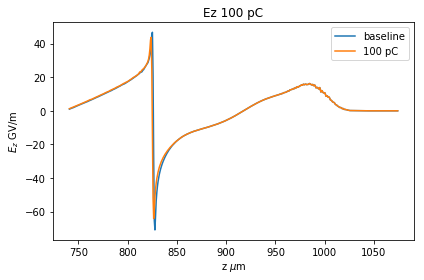

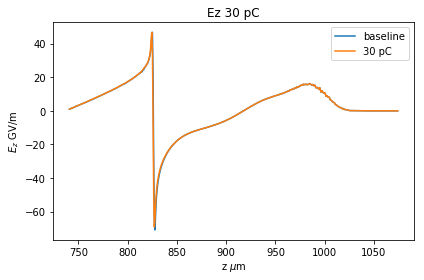

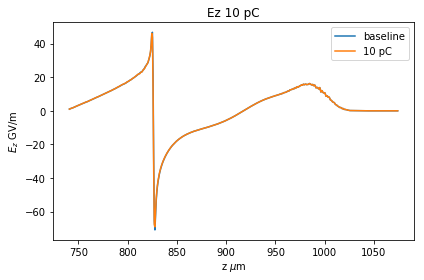

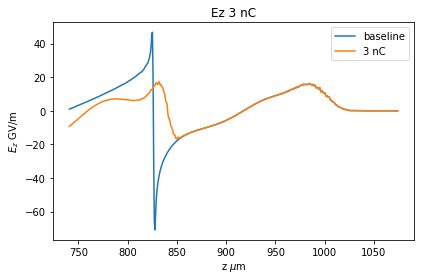

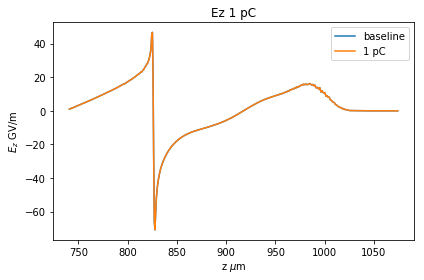

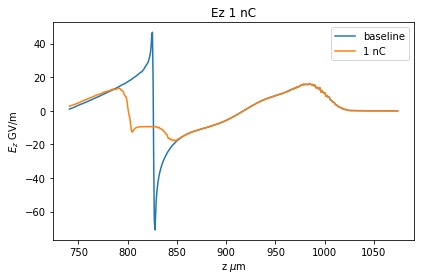

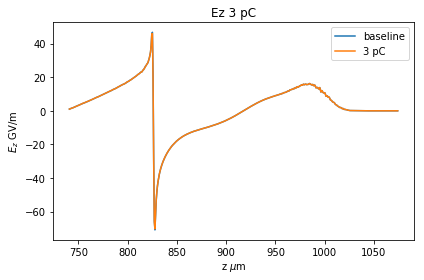

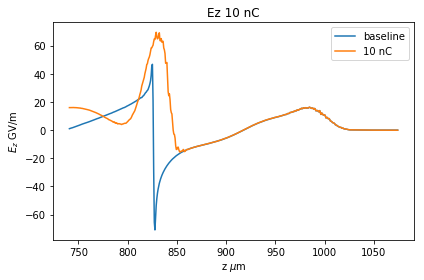

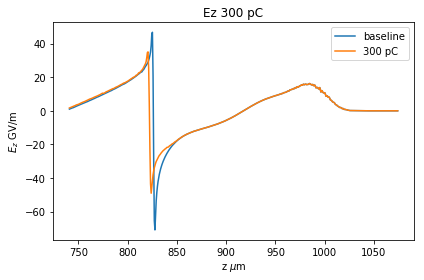

In [10]:
# what index are we getting the fields from?
observation_point = -2.*witness_sigma_z * 1.e6

# do we want to make the plots again?
make_ez_plots = True
# Move slightly off axis to reduce noise
z_axis_idx = np.shape(rgrid)[0]/2+5

E_wake = np.zeros(np.shape(witness_Qs.keys()))
Q = np.zeros(np.shape(witness_Qs.keys()))

z_window = constants.speed_of_light*dump_period*dt * 1.e6

# It helps to plot the on-axis E_z to make sure things make sense
idx = 0
for key in witness_Qs.keys():
    dir_name = './data/' + key +'/hdf5'
    ts = OpenPMDTimeSeries(dir_name)
    Ez, meta = ts.get_field(field='E', coord='z', iteration=step_num)
    zs, uz = ts.get_particle(var_list=['z','uz'], species='electrons', iteration=step_num)
    z_obs = np.average(zs) + observation_point-z_window
    E_test = compute_ez(z_obs, Ez[z_axis_idx,:]) - compute_ez(z_obs, Ez_base[z_axis_idx,:])
    E_wake[idx] = E_test
    Q[idx] = witness_Qs[key]
    idx += 1

    if make_ez_plots:
        fig, ax = plt.subplots()

        plt.plot(zgrid*1.e6,Ez_base[z_axis_idx, :]*1.e-9, label='baseline')
        plt.plot(zgrid*1.e6,Ez[z_axis_idx, :]*1.e-9, label=key)

        plt.legend()
        plt.title('Ez '+key)
        plt.xlabel(r'z $\mu$m')
        plt.ylabel(r'$E_z$ GV/m')
        plt.tight_layout()

        filename = 'fields'+key+'.pdf'
        plt.savefig(filename)

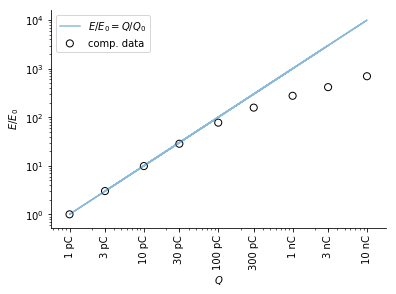

In [12]:
fig, ax = plt.subplots()

ax.spines["top"].set_visible(False)    
ax.spines["right"].set_visible(False)    

# plot log-log since we're spanning decades
ax.set_yscale('log')
ax.set_xscale('log')

# plot a straight line for comparison
Q_linear = []
x_labels = []
x_values = []
for key in witness_Qs.keys():
    x_labels.append(key)
    Q_linear.append(witness_Q_labels[key])

# make sure everything is normalized
Q[:] = Q[:]/np.min(Q)
E_wake[:] = E_wake[:]/np.min(E_wake)
Q_linear[:] = Q_linear[:]/np.min(Q_linear)

Delta_E_wake = (np.array(E_wake) - np.array(Q_linear))

plt.plot(Q_linear, Q_linear, label=r'$E/E_0 = Q/Q_0$', alpha=0.5)
plt.scatter(np.abs(Q), E_wake, marker='o', s=50, facecolors='none', edgecolors='k', label='comp. data')

plt.xticks(Q, x_labels, rotation='vertical')
plt.xlabel(r'$Q$')
plt.ylabel(r'$E/E_0$')
plt.legend()
plt.savefig('response_vs_charge.pdf')

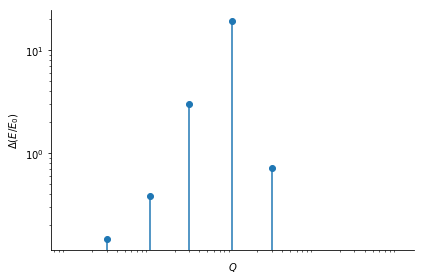

In [147]:
# make a stem plot showing the difference from the nominal

fig, ax = plt.subplots()

ax.spines["top"].set_visible(False)    
ax.spines["right"].set_visible(False)    

# plot log-log since we're spanning decades
ax.set_yscale('log')
ax.set_xscale('log')

markerline, stemline, baseline = plt.stem(np.abs(Q), Delta_E_wake, c='k')
plt.setp(baseline, color='w', linewidth=2)

plt.xticks(x_values, x_labels, rotation='vertical')
plt.xlabel(r'$Q$')
plt.ylabel(r'$\Delta \left (E/E_0\right)$')
plt.tight_layout()
plt.savefig('nonlinear_deviation.png')